In [18]:
import torch

import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import sys

"""
"""
def adj_to_bias(adj, sizes, n_neigh=1):
    """ Make mask based on adj for the convience of performing softmax

    Parameters
    ----------
    adj: np.ndarray, shape: (batch number, adj, adj)
    sizes: list, correspond with adj.shape[0]
    n_neigh: int, breadth size
    """
    n_graph = adj.shape[0]
    bias = np.empty(adj.shape)
    for g_idx in range(n_graph):
        bias[g_idx] = np.eye(adj.shape[1])
        for _ in range(n_neigh):
            bias[g_idx] = np.matmul(bias[g_idx], (np.eye(adj.shape[1]) + adj[g_idx]))
        
        for i in range(sizes[g_idx]):
            for j in range(sizes[g_idx]):
                if bias[g_idx][i][j] > 0.0:
                    bias[g_idx][i][j] = 1

    return -1e9 * (1.0 - bias)

""" Subsequence Code Are from github/GCN
"""

def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def load_data(dataset_str): # {'pubmed', 'citeseer', 'cora'}
    """Load data."""
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    idx_test = test_idx_range.tolist()
    idx_train = range(len(y))
    idx_val = range(len(y), len(y)+500)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    print(adj.shape)
    print(features.shape)

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask

def load_random_data(size):

    adj = sp.random(size, size, density=0.002) # density similar to cora
    features = sp.random(size, 1000, density=0.015)
    int_labels = np.random.randint(7, size=(size))
    labels = np.zeros((size, 7)) # Nx7
    labels[np.arange(size), int_labels] = 1

    train_mask = np.zeros((size,)).astype(bool)
    train_mask[np.arange(size)[0:int(size/2)]] = 1

    val_mask = np.zeros((size,)).astype(bool)
    val_mask[np.arange(size)[int(size/2):]] = 1

    test_mask = np.zeros((size,)).astype(bool)
    test_mask[np.arange(size)[int(size/2):]] = 1

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]
  
    # sparse NxN, sparse NxF, norm NxC, ..., norm Nx1, ...
    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask

def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx

def standardize_data(f, train_mask):
    """Standardize feature matrix and convert to tuple representation"""
    # standardize data
    f = f.todense()
    mu = f[train_mask == True, :].mean(axis=0)
    sigma = f[train_mask == True, :].std(axis=0)
    f = f[:, np.squeeze(np.array(sigma > 0))]
    mu = f[train_mask == True, :].mean(axis=0)
    sigma = f[train_mask == True, :].std(axis=0)
    f = (f - mu) / sigma
    return f

def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features.todense(), sparse_to_tuple(features)

def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)

def preprocess_adj_bias(adj):
    num_nodes = adj.shape[0]
    adj = adj + sp.eye(num_nodes)  # self-loop
    adj[adj > 0.0] = 1.0
    if not sp.isspmatrix_coo(adj):
        adj = adj.tocoo()
    adj = adj.astype(np.float32)
    indices = np.vstack((adj.col, adj.row)).transpose()  # This is where I made a mistake, I used (adj.row, adj.col) instead
    # return tf.SparseTensor(indices=indices, values=adj.data, dense_shape=adj.shape)
    return indices, adj.data, adj.shape


In [19]:
import time
import numpy as np
import torch
from torch import optim
# from utils import (adj_to_bias, load_data, preprocess_features)

dataset = 'cora'

adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(dataset)
features, spars = preprocess_features(features)

n_node = features.shape[0]
ft_size = features.shape[1]
n_class = y_train.shape[1]
adj = np.array(adj)

(2708, 2708)
(2708, 1433)


In [20]:
import sys 
sys.path.append('/Users/cashbus/Documents/工作/任务5-图/')
from aggregator import MeanAggregator
from sampler import LayerNeighborSampler
from minibatch import EdgeMinibatchIter, EdgeMinibatchIterSupervised
from models import GraphSage_supervised
from utils import *
import copy
import tensorflow as tf
import pandas as pd

In [2]:
data = './data/col_4.csv'
df = pd.read_csv(data, header=None)
G, adj_list, userid2idx, degree, edges = make_adj_list(df.iloc[:, :2].values)
fake_feats, fake_lables = make_fake_feat(G.nodes(), 50)

In [3]:
Gsage_supervised = GraphSage_supervised(features, edges, adj_list, fake_lables, degree, userid2idx, 200, 20)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
Gsage_supervised.main()

Instructions for updating:
Use keras.layers.dense instead.
aff:Tensor("Sum:0", shape=(200,), dtype=float32)
neg_aff:Tensor("MatMul:0", shape=(200, 4), dtype=float32)
loss:Tensor("add:0", shape=(), dtype=float32)

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
batch_idx_for_training:50
batch_idx_for_training:100
batch_idx_for_training:150
batch_idx_for_training:200
batch_idx_for_training:250
batch_idx_for_training:300
batch_idx_for_training:350
batch_idx_for_training:400
batch_idx_for_training:450
batch_idx_for_training:500
batch_idx_for_training:550
batch_idx_for_training:600
batch_idx_for_training:650
batch_idx_for_training:700
batch_idx_for_training:750
batch_idx_for_training:800
batch_idx_for_training:850
batch_idx_for_training:900
batch_idx_for_train

Node Degree
0 16
1 9
2 10
3 6
4 3
5 4
6 4
7 4
8 5
9 2
10 3
11 1
12 2
13 5
14 2
15 2
16 2
17 2
18 2
19 3
20 2
21 2
22 2
23 5
24 3
25 3
26 2
27 4
28 3
29 4
30 4
31 6
32 12
33 17


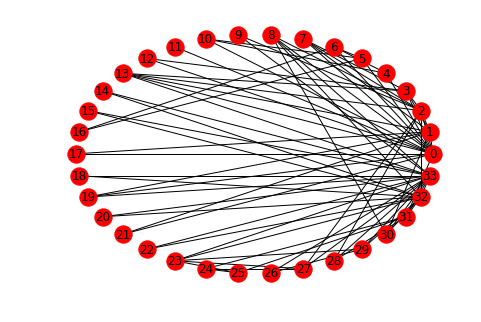

In [75]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.karate_club_graph()
print("Node Degree")
for v in G:
    print('%s %s' % (v, G.degree(v)))

nx.draw_circular(G, with_labels=True)
plt.show()

In [76]:
import numpy as np
import scipy

In [77]:
A = nx.to_scipy_sparse_matrix(G, nodelist=G.nodes(), weight='weight').todense()
n,m = A.shape

In [80]:
diags = A.sum(axis=1).flatten()
D = scipy.sparse.spdiags(diags, [0], m, n, format='csr').todense()

In [81]:
DA = np.linalg.inv(D)@A

In [82]:
DA[17]

matrix([[ 0.5,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ]])